In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent

from VAE_OPTIMIZATION_R2 import _dataset, VAE, study, compare_distributions_binned_aux, compare_distributions_binned

In [5]:
import time
time.sleep(1)

## Loading the Study

In [2]:

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 67
Best trial:
  Value: 0.9513708416651321
  Params: 
    alpha: 3671
    hidden_size: 26
    lr: 0.00020993971000460843
    n_layers_decoder: 6
    n_layers_encoder: 3
    n_units_decoder_l0: 125
    n_units_decoder_l1: 335
    n_units_decoder_l2: 415
    n_units_decoder_l3: 85
    n_units_decoder_l4: 225
    n_units_decoder_l5: 115
    n_units_encoder_l0: 500
    n_units_encoder_l1: 410
    n_units_encoder_l2: 110
 TRIAL NUMBER: 66


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study)

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
#name = "re-reconstruction_vs_data_trial_38" FOI O 38 DA RECONSTRUCTION!!!!!
#name = "re-reconstruction_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_R2-Data_vs_Reconstruction_trial_66"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[38], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=500, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=500, out_features=410, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=410, out_features=110, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=110, out_features=26, bias=True)
  )
  (hidden2mu): Linear(in_features=26, out_features=26, bias=True)
  (hidden2log_var): Linear(in_features=26, out_features=26, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=26, out_features=125, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=125, out_features=335, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=335, out_features=415, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=415, out_features=85, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=85, 

### Load data

In [15]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 26)

Mean: 0.001818402 	Std: 0.99196494
Mean: -0.016899971 	Std: 0.99323344
Mean: 0.04771669 	Std: 0.99981505
Mean: 0.011061621 	Std: 1.0036802
Mean: -0.021063227 	Std: 0.9902969
Mean: 0.01477082 	Std: 0.9902198
Mean: 0.0012098115 	Std: 0.98874515
Mean: 0.005943293 	Std: 0.98810804
Mean: -4.268332e-05 	Std: 0.9911593
Mean: -8.3242776e-05 	Std: 0.98937327
Mean: 0.0033569217 	Std: 0.9869028
Mean: 0.13743481 	Std: 1.0630803
Mean: 0.002542317 	Std: 1.0316775
Mean: 0.004361187 	Std: 1.0129975
Mean: 0.014897874 	Std: 0.99818933
Mean: 0.0014029943 	Std: 0.99211276
Mean: 0.0064828894 	Std: 0.9935778
Mean: 0.005075359 	Std: 0.97767836
Mean: -0.018403403 	Std: 1.0000864
Mean: -0.0053650867 	Std: 0.9994932
Mean: -0.016309563 	Std: 0.9940778
Mean: 0.032881577 	Std: 0.9954035
Mean: 0.004217256 	Std: 0.9943079
Mean: 0.0024743667 	Std: 0.9906115
Mean: 0.026833624 	Std: 0.9901792
Mean: 0.01164578 	Std: 0.99320924


<ipython-input-8-6f0d6456a17b>:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



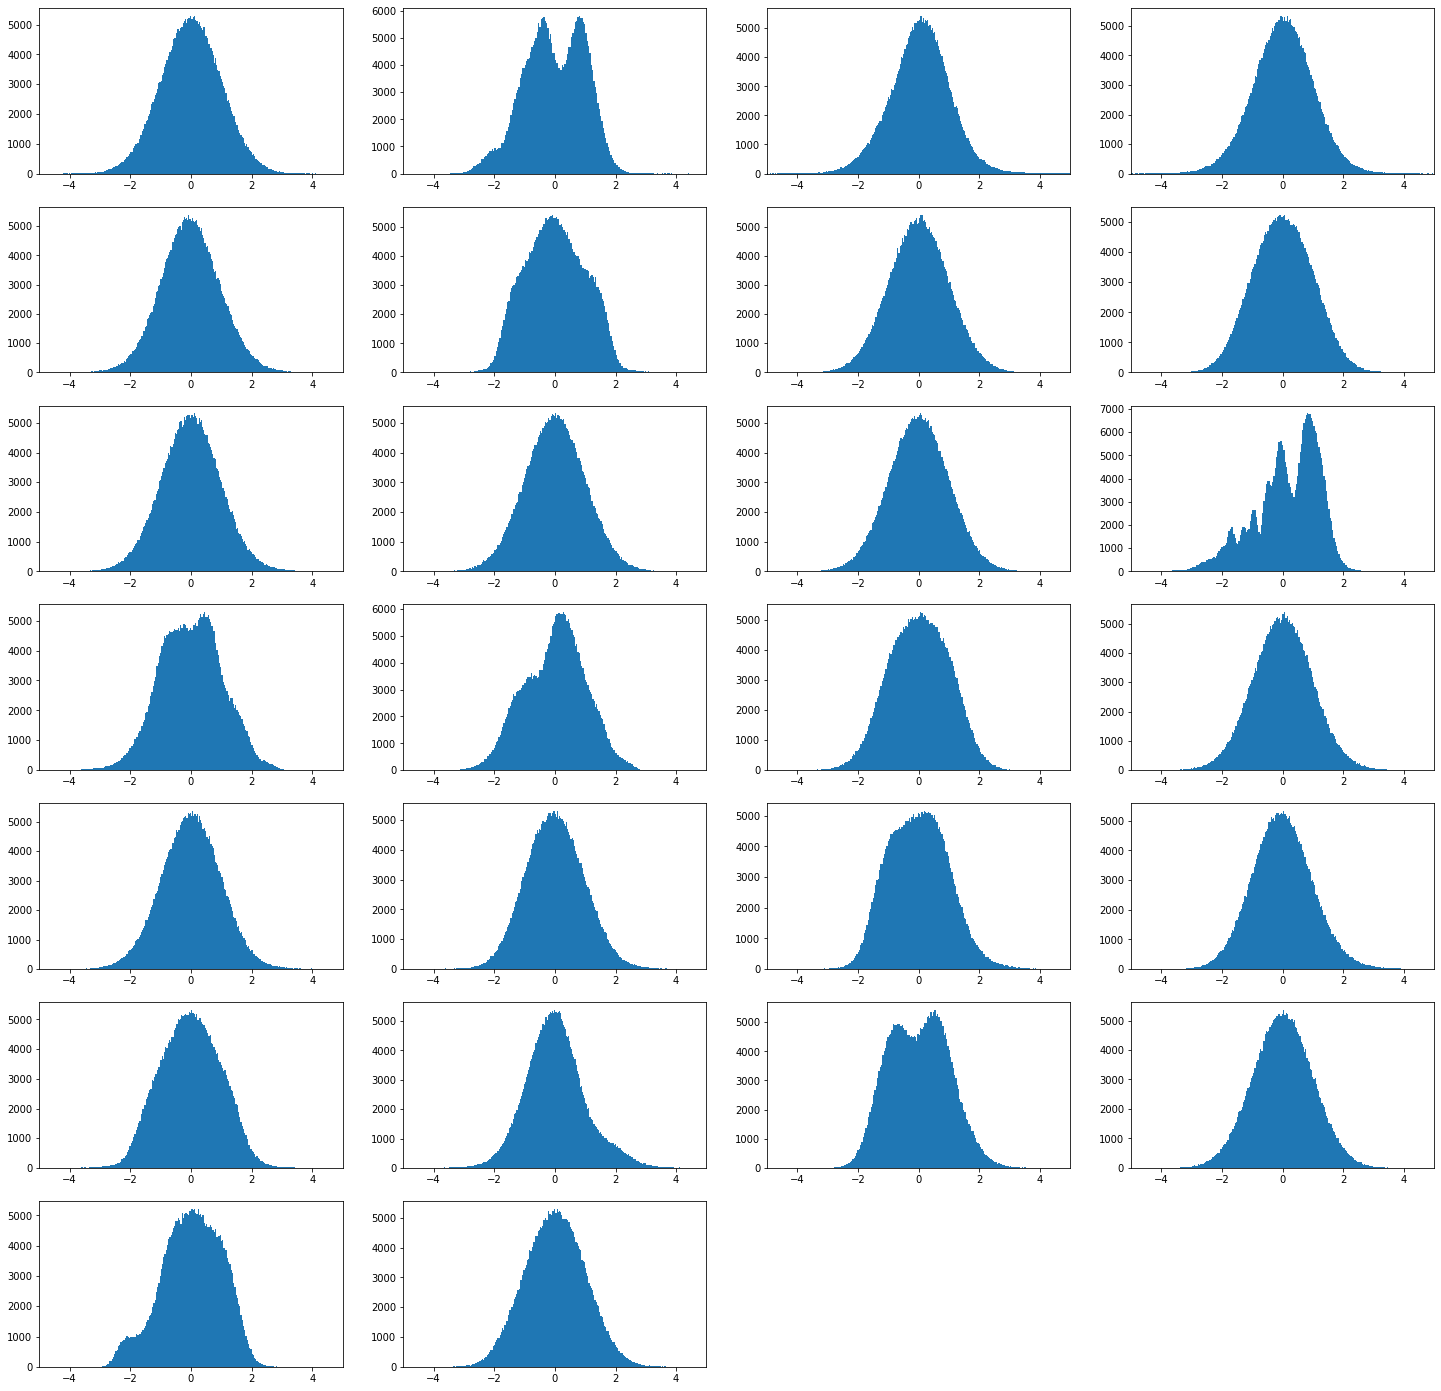

In [8]:

fig = plt.figure(figsize=[25,25])
i = 0

for x in range(hidden.shape[1]):
    axes = fig.add_subplot(7,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())


fig.show()

## Bkg Data vs Random Sampling Decoding

In [9]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_MET,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT
count,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,...,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000
mean,-0.155064,-0.557374,0.032921,0.001756,-0.539606,0.003971,-0.369836,-0.214569,-0.535512,-0.624362,...,0.669696,-0.403870,-0.927586,-0.356212,-1.268535,0.065727,-0.381818,-0.844640,0.359586,-0.868750
std,0.421021,0.177423,0.815577,0.018760,0.025396,0.072798,0.517642,0.369080,0.235159,0.132983,...,0.544807,0.353544,0.425897,0.197190,0.770770,0.326524,0.309130,0.885760,0.519641,0.183904
min,-2.285323,-1.110065,-4.175634,-1.051849,-0.819075,-3.175414,-0.914246,-1.597761,-1.253106,-1.107897,...,-0.785037,-1.275421,-2.635320,-0.917821,-3.415555,-1.477790,-1.155381,-2.709454,-1.282401,-1.509978
25%,-0.298511,-0.679338,-0.022972,-0.002439,-0.551911,-0.002332,-0.865499,-0.471030,-0.706000,-0.716751,...,0.299229,-0.693429,-1.222384,-0.506910,-1.795451,-0.015261,-0.683627,-1.700454,-0.198273,-0.995100
50%,-0.003855,-0.659660,-0.002211,0.001863,-0.539432,0.008099,-0.842374,-0.221526,-0.554886,-0.628076,...,0.641582,-0.408489,-0.927084,-0.384687,-1.291441,0.006850,-0.305687,-0.651383,0.831019,-0.884739
75%,0.007539,-0.419592,0.256893,0.006531,-0.529294,0.016130,0.185076,0.032677,-0.384736,-0.534668,...,1.007822,-0.117487,-0.632205,-0.236436,-0.781757,0.176782,-0.096616,0.006381,0.856969,-0.752680
max,1.891071,0.571637,2.482182,1.561321,0.297738,0.074251,1.275149,1.711082,0.610031,0.114749,...,3.375738,0.654829,0.741357,0.777000,2.232279,1.741452,0.663754,0.312964,0.910254,0.159286


In [10]:
bkg.shape, sample.shape

((341121, 69), (341121, 69))

In [20]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += compare_distributions_binned_aux(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("WD_SCORE:", WD_SCORE/len(features))
    #print("WD_Score:", compare_distributions_binned(background, bkg_weights, sample, np.ones(bkg_weights.shape), bins=100))
    #print("R2_SCORE:", R2_SCORE/len(features))

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

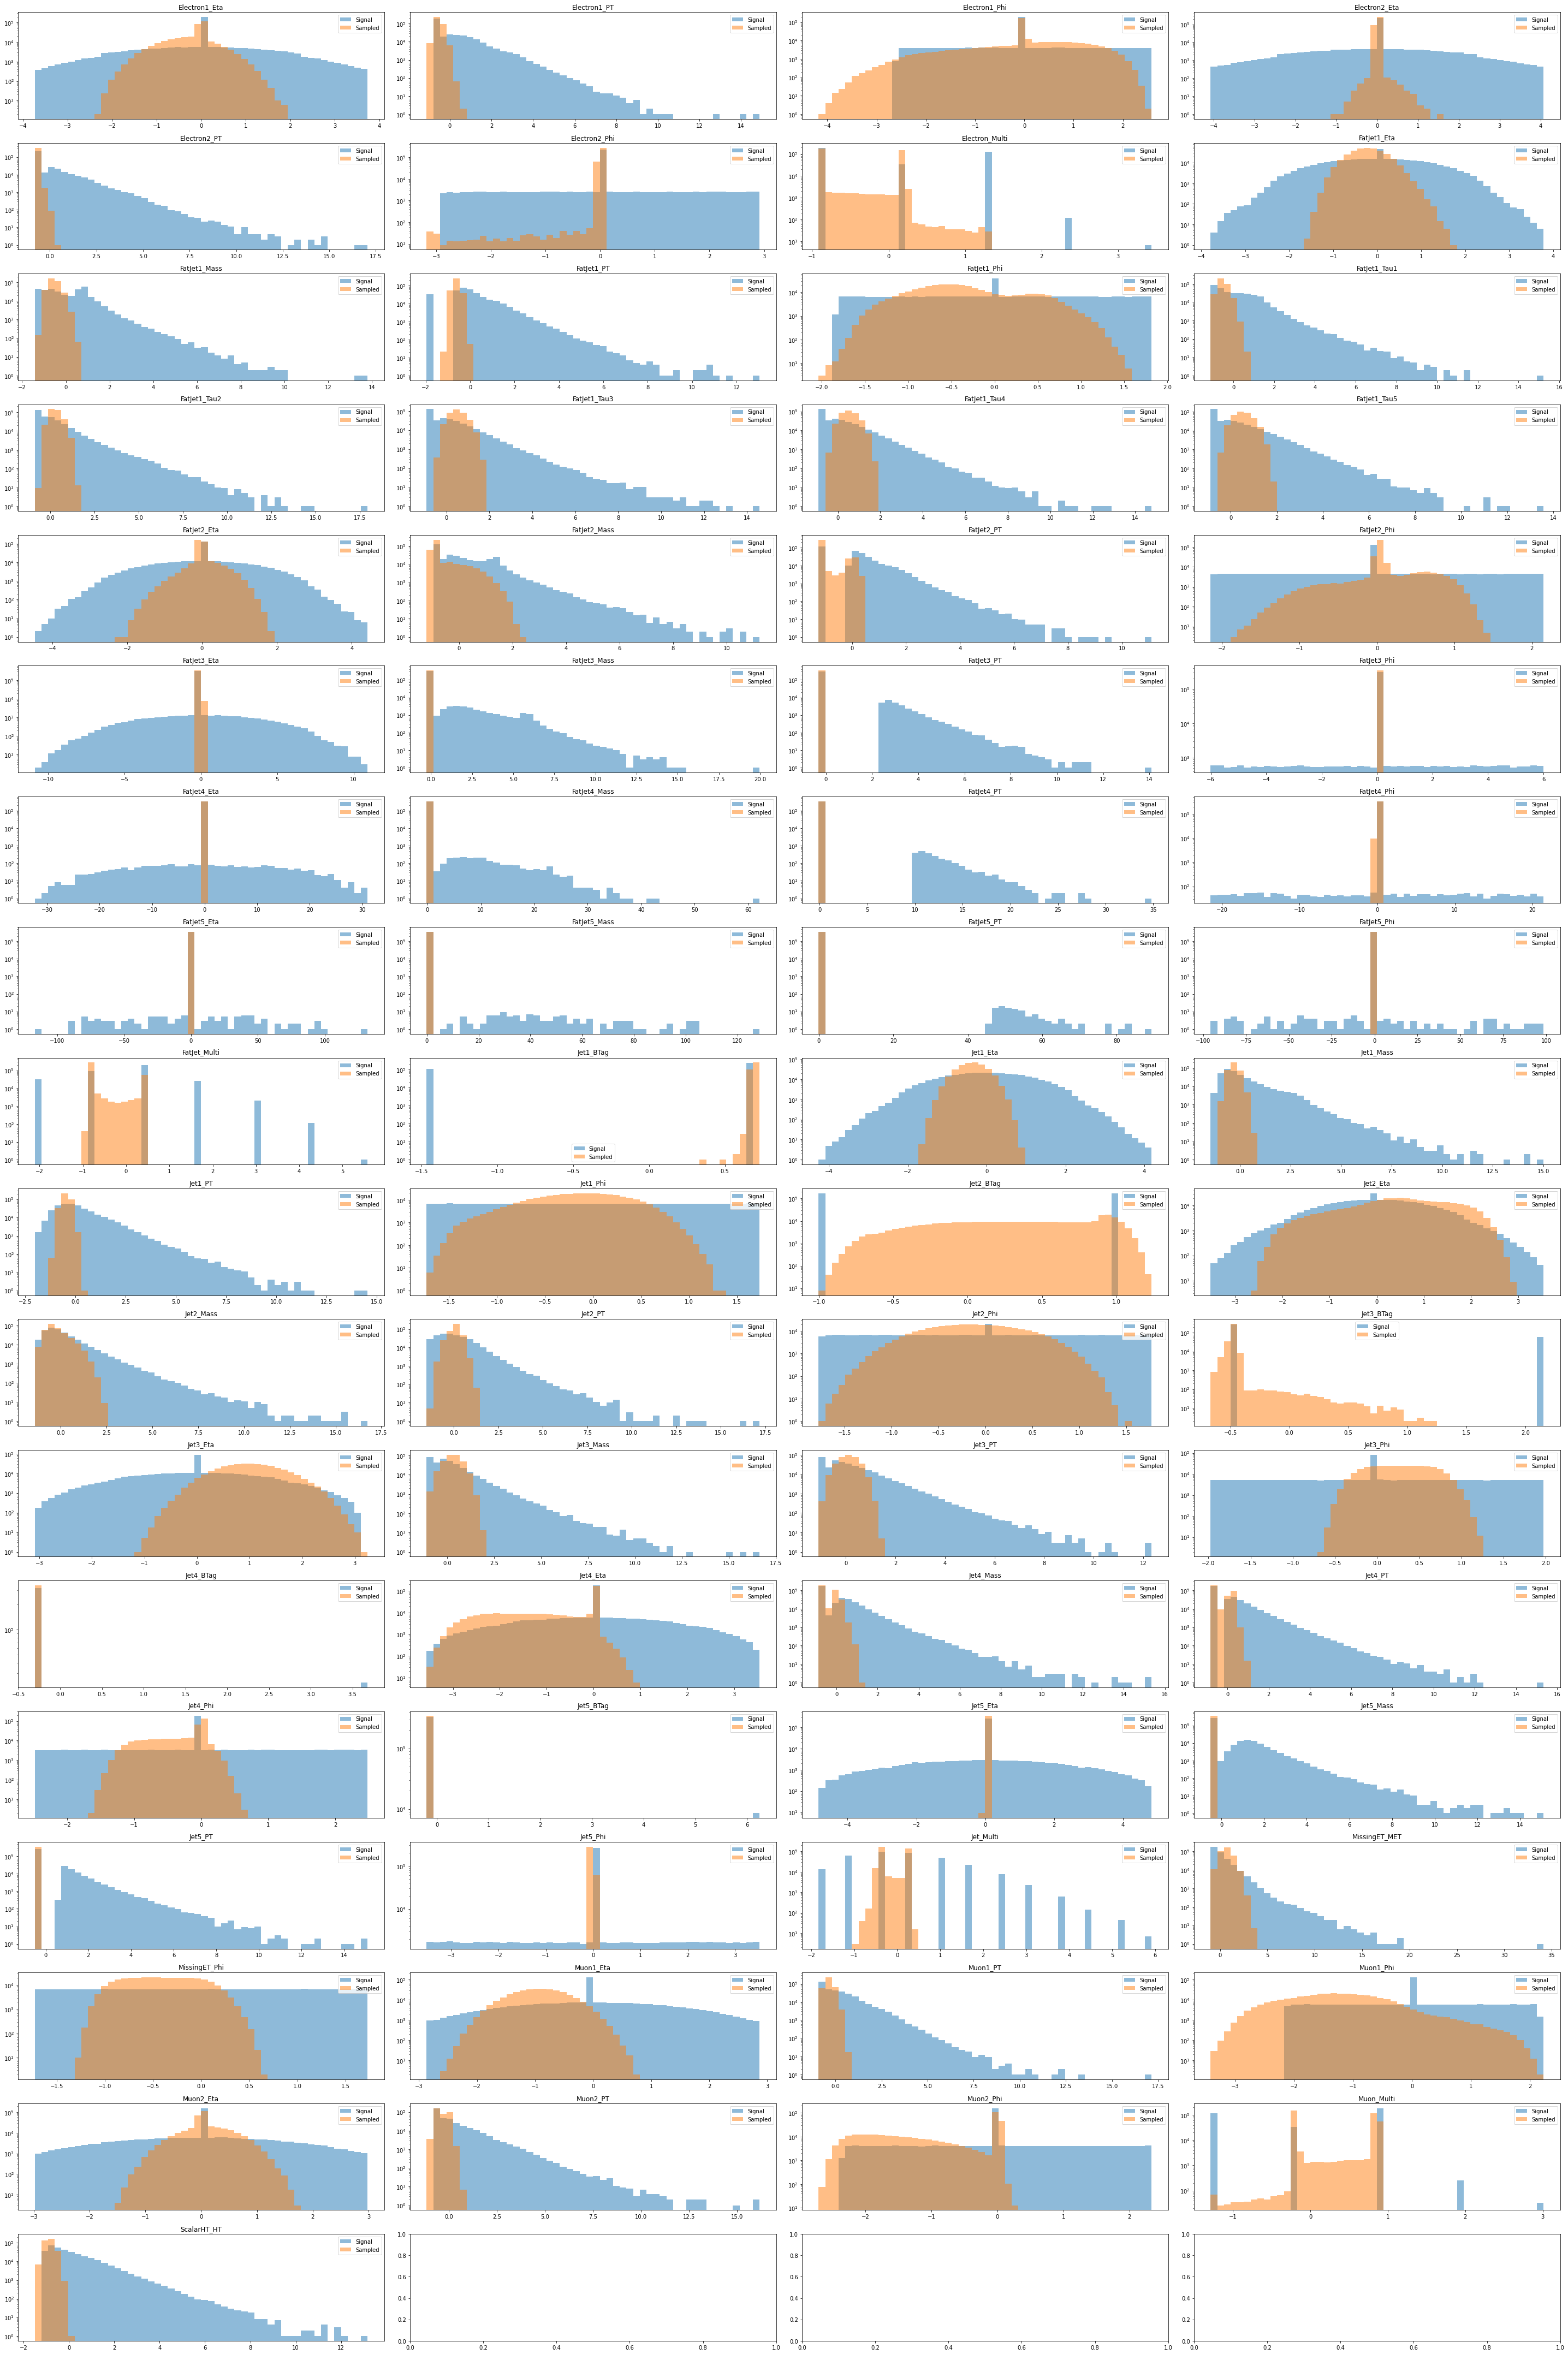

In [21]:
plot_graphs2(bkg, sample)

In [24]:
print("WD_Score:", compare_distributions_binned(bkg.to_numpy(), bkg_weights.to_numpy(), sample.to_numpy(), np.ones(bkg_weights.shape), bins=100))

WD_Score: 6.999788846230572


## Bkg Data vs Reconstruction

In [25]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

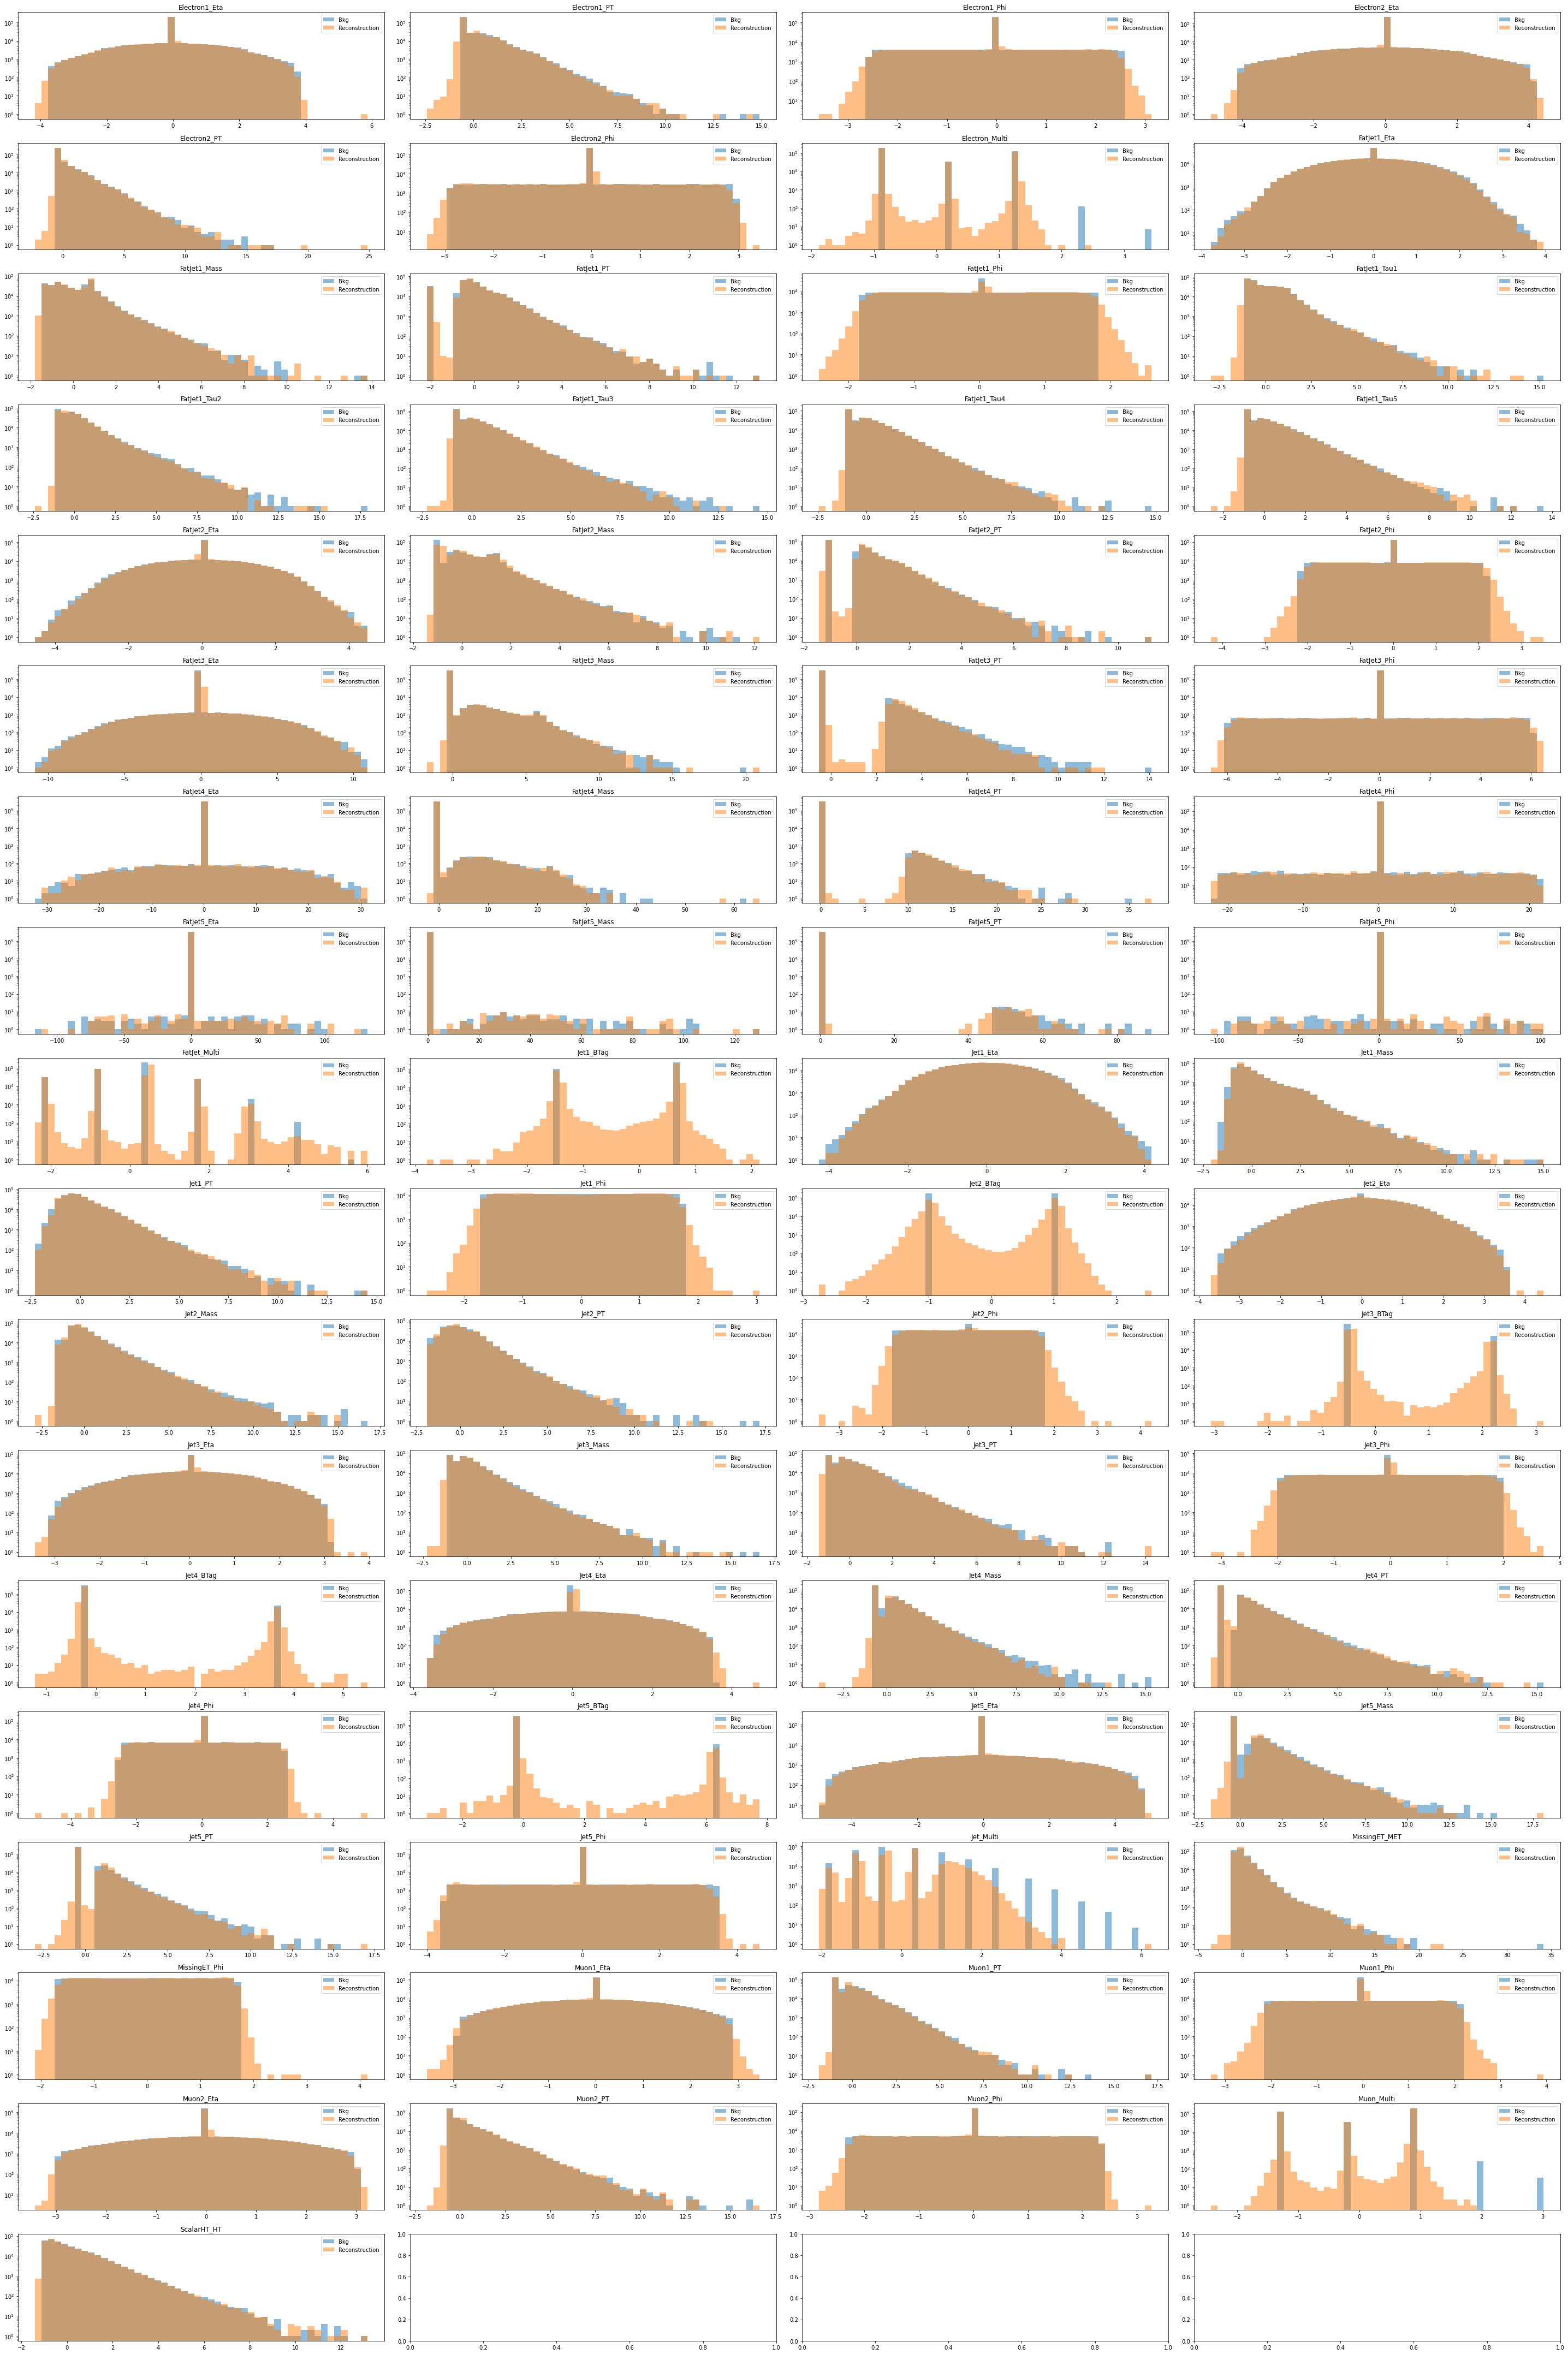

In [26]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [27]:
print("WD_Score:", compare_distributions_binned(bkg.to_numpy(), bkg_weights.to_numpy(), x_out, np.ones(bkg_weights.shape), bins=100))

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

## Plot error distributions and ROC Score

Load data

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)
signal['name'].unique()

Plot

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
def plot_graphs3(data, bins=50, num_cols=4):

    # Plot creation
    features = list(data['name'].unique())

    #num_rows = int(np.ceil((len(list(features)) - 1) / num_cols)) +1
    #fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    #i= 0


    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        #row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        #i += 1

        # Input to the model
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])#[:100000]
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        # Pass input through model
        _, _, output, _ = model.test_step(sData)

        # Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    # Now we are going to find the maximum of all distributions
    max_of_dist = max(map(lambda x: max(x), distributions.values()))

    # Normalize the distributions
    # This way all values should be between 0 and one
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    # distributions =list(map(lambda x: x/max_of_dist, distributions))


    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        #x = x.replace(".h5", "")
        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range)

        # Plot rocs
        # ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    # PLOT ROC
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 
            score = score / max_of_dist

            #print(labels.shape, weights.shape, score.shape, x)
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))

    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

In [ ]:
data = pd.concat([signal, bkg])
del signal, bkg

In [ ]:
plot_graphs3(data)

## Calculate ROC Score over HT Distribution

In [ ]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()

In [ ]:
# Normalizing the data
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] - min(signal['ScalarHT_HT'])
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] - min(bkg['ScalarHT_HT'])
max_value = max(max(signal['ScalarHT_HT']), max(bkg['ScalarHT_HT']))
bkg['ScalarHT_HT'] = bkg['ScalarHT_HT'] / max_value
signal['ScalarHT_HT'] = signal['ScalarHT_HT'] / max_value

In [ ]:
fig_roc, ax_roc = plt.subplots(figsize=(10,10))
from sklearn.metrics import roc_auc_score, roc_curve
for x in signal['name'].unique():

    current_signal = signal[signal['name'] == x]['ScalarHT_HT']
    current_bkg = bkg['ScalarHT_HT']


    # Labels
    bkg_labels = np.zeros(current_bkg.shape[0]).astype(int)
    signal_labels = np.ones(current_signal.shape[0]).astype(int)
    labels = np.concatenate([bkg_labels, signal_labels])

    # Score
    score = pd.concat([bkg['ScalarHT_HT'], signal[signal['name'] == x]['ScalarHT_HT']])

    # Weights
    weights = pd.concat([
                        bkg['weights'], 
                        signal[signal['name'] == x]['weights']
                        ])


    fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights,
                    )
            
            
    ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
    ax_roc.plot([0,1],[0,1], 'k--')

    print(f"ROC SCORE for {x.replace('.h5', '')}:", 
            roc_auc_score(y_true=labels, 
            y_score=score,
            sample_weight=weights))

fig_roc.show()
ax_roc.set_title(f"BKG vs Signals (HT)")
ax_roc.legend()